In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from pts.model.tempflow import TempFlowEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator


/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Prepeare data set

In [4]:
dataset = get_dataset("solar_nips", regenerate=False)

In [5]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [6]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [20]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self.frequency = timestamp.freq
/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:215: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  freq=data[FieldName.START].freq,
/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:164: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  freq=data[FieldName.START].freq,
/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/gluo

In [8]:
dataset_train

## Evaluator

In [9]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

## `GRU-Real-NVP`

In [27]:
it_tr = iter(dataset.train)

In [47]:
len(dataset.test)

959

(0.0, 1000.0)

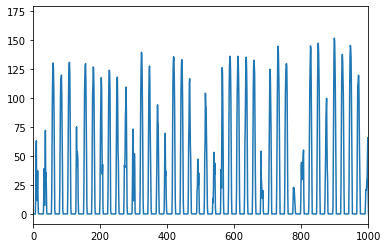

In [44]:
plt.plot(entry['target'])
plt.xlim(0, 1000)

In [55]:
dataset.metadata.prediction_length

24

In [59]:
552/24

23.0

In [16]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [49]:
int(dataset.metadata.feat_static_cat[0].cardinality)

137

In [53]:
dataset.train

TypeError: 'FileDataset' object is not subscriptable

In [10]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    n_blocks=4,
    trainer=Trainer(device=device,
                    epochs=45,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [ ]:
predictor = estimator.train(dataset_train)


In [ ]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                predictor=predictor,
                                                num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

### Metrics

In [12]:
agg_metric

{'0_MSE': 2351.8306129092266,
 '0_abs_error': 4652.809631347656,
 '0_abs_target_sum': 11060.849975585938,
 '0_abs_target_mean': 65.83839271182106,
 '0_seasonal_error': 27.38071950246711,
 '0_MASE': 1.0115844812826222,
 '0_MAPE': 2.858054411256468,
 '0_sMAPE': 1.3198993660154799,
 '0_MSIS': 7.206511954925648,
 '0_QuantileLoss[0.05]': 1216.1174889594317,
 '0_Coverage[0.05]': 0.07738095238095237,
 '0_QuantileLoss[0.1]': 1979.1948230147364,
 '0_Coverage[0.1]': 0.09523809523809525,
 '0_QuantileLoss[0.15]': 2647.117002633214,
 '0_Coverage[0.15]': 0.11904761904761904,
 '0_QuantileLoss[0.2]': 3086.080462411046,
 '0_Coverage[0.2]': 0.1369047619047619,
 '0_QuantileLoss[0.25]': 3515.0227022340987,
 '0_Coverage[0.25]': 0.17261904761904762,
 '0_QuantileLoss[0.3]': 3928.806998305861,
 '0_Coverage[0.3]': 0.29761904761904756,
 '0_QuantileLoss[0.35]': 4213.860076557854,
 '0_Coverage[0.35]': 0.41666666666666663,
 '0_QuantileLoss[0.4]': 4448.520100225602,
 '0_Coverage[0.4]': 0.625,
 '0_QuantileLoss[0.45]

In [13]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.4136882113665552
ND: 0.5202624555868226
NRMSE: 1.0837225782600173
MSE: 1114.0739785354504


In [47]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.36531966950112466
ND: 0.45434020382814283
NRMSE: 0.9820216603495642
MSE: 914.7868680304274


In [48]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.2873863376280519
ND-Sum: 0.35970480888579265
NRMSE-Sum: 0.7184166842326591
MSE-Sum: 9189074.285714285


## `GRU-MAF`

In [17]:
estimator = TempFlowEstimator(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=552,
    freq=dataset.metadata.freq,
    scaling=True,
    dequantize=True,
    flow_type='MAF',
    trainer=Trainer(device=device,
                    epochs=25,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64)
)

In [18]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

98it [00:10,  9.05it/s, avg_epoch_loss=-7.36, epoch=0]
99it [00:10,  9.19it/s, avg_epoch_loss=-136, epoch=1]
99it [00:10,  9.12it/s, avg_epoch_loss=-164, epoch=2]
98it [00:10,  8.91it/s, avg_epoch_loss=-179, epoch=3]
98it [00:10,  9.09it/s, avg_epoch_loss=-188, epoch=4]
99it [00:10,  9.05it/s, avg_epoch_loss=-194, epoch=5]
98it [00:10,  9.04it/s, avg_epoch_loss=-198, epoch=6]
98it [00:10,  8.97it/s, avg_epoch_loss=-201, epoch=7]
97it [00:10,  8.90it/s, avg_epoch_loss=-204, epoch=8]
99it [00:10,  9.07it/s, avg_epoch_loss=-206, epoch=9]
99it [00:10,  9.09it/s, avg_epoch_loss=-207, epoch=10]
98it [00:11,  8.90it/s, avg_epoch_loss=-209, epoch=11]
99it [00:10,  9.02it/s, avg_epoch_loss=-210, epoch=12]
98it [00:10,  8.95it/s, avg_epoch_loss=-211, epoch=13]
99it [00:10,  9.21it/s, avg_epoch_loss=-212, epoch=14]
98it [00:10,  9.00it/s, avg_epoch_loss=-213, epoch=15]
99it [00:10,  9.21it/s, avg_epoch_loss=-214, epoch=16]
98it [00:10,  8.95it/s, avg_epoch_loss=-215, epoch=17]
98it [00:11,  8.88i

### Metrics

In [19]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3855313301520275
ND: 0.48820539490099113
NRMSE: 1.018839692673421
MSE: 984.6672641166102


In [20]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.3268739166960563
ND-Sum: 0.40321702146475014
NRMSE-Sum: 0.75586334994103
MSE-Sum: 10171980.5


## `Transformer-MAF`

In [16]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=552,
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*4,
    flow_type='MAF',
    dequantize=True,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

In [17]:
predictor = estimator.train(dataset_train)
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

99it [00:26,  3.70it/s, avg_epoch_loss=-82.7, epoch=0]
Running evaluation: 7it [00:00, 121.58it/s]
Running evaluation: 7it [00:00, 129.89it/s]
Running evaluation: 7it [00:00, 133.02it/s]
Running evaluation: 7it [00:00, 133.71it/s]
Running evaluation: 7it [00:00, 129.68it/s]
Running evaluation: 7it [00:00, 130.11it/s]
Running evaluation: 7it [00:00, 135.91it/s]
Running evaluation: 7it [00:00, 134.94it/s]
Running evaluation: 7it [00:00, 127.03it/s]
Running evaluation: 7it [00:00, 131.79it/s]
Running evaluation: 7it [00:00, 131.80it/s]
Running evaluation: 7it [00:00, 129.62it/s]
Running evaluation: 7it [00:00, 130.80it/s]
Running evaluation: 7it [00:00, 134.32it/s]
Running evaluation: 7it [00:00, 135.98it/s]
Running evaluation: 7it [00:00, 132.59it/s]
Running evaluation: 7it [00:00, 132.17it/s]
Running evaluation: 7it [00:00, 131.03it/s]
Running evaluation: 7it [00:00, 130.69it/s]
Running evaluation: 7it [00:00, 130.72it/s]
Running evaluation: 7it [00:00, 132.53it/s]
Running evaluation: 7

### Metrics

In [11]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.37264046134993567
ND: 0.5043621354947913
NRMSE: 0.9928759300158241
MSE: 935.1208752979203


In [12]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.30787625107438427
ND-Sum: 0.4188356756894787
NRMSE-Sum: 0.7504274205713227
MSE-Sum: 10026199.285714285
